# E2 - Création d'un *classifier* de Porte

## Connexion au Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
zip_path = '/content/gdrive/My Drive/microsoft_ia/IA/DataSet_Classification.zip'

# Copie le fichier zip complet sur l'environnement:
!cp "{zip_path}" .

# Dezippe le fichier dans l'environnement Colab:
!unzip -q DataSet_Classification

# Suppression du fichier zip de l'environnement:
#!rm DataSet_Classification

# Vérification de l'importation des images dans l'environnement virtuel:
!ls

DataSet_Classification	DataSet_Classification.zip  gdrive  sample_data


## Importation des librairies

In [5]:
import cv2
from google.colab.patches import cv2_imshow

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras import utils as np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


## Importation et définition des ensembles d'images Train et Valid
### Images Train

In [6]:
# Définitions des chemins vers les dossiers contenant les images Train et Valid:
data_direction_train = "DataSet_Classification/Cropped/RGB/train"
data_direction_val = "DataSet_Classification/Cropped/RGB/val"
data_direction_test = "DataSet_Classification/Cropped/RGB/test"

categories_train = os.listdir(data_direction_train)
print(f"Train : {categories_train}")

categories_val = os.listdir(data_direction_val)
print(f"Valid : {categories_val}")

categories_test = os.listdir(data_direction_test)
print(f"Test : {categories_test}")

for category in categories_train:
    path = os.path.join(data_direction_train, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))

Train : ['Closed', 'Semi', 'Open']
Valid : ['Closed', 'Semi', 'Open']
Test : ['Closed', 'Semi', 'Open']


In [7]:
Open_train = len(os.listdir("DataSet_Classification/Cropped/RGB/train/Open"))
Semi_train = len(os.listdir("DataSet_Classification/Cropped/RGB/train/Semi"))
Closed_train = len(os.listdir("DataSet_Classification/Cropped/RGB/train/Closed"))

print(f"Nombre d\'images Open : {Open_train}")
print(f"Nombre d\'images Semi : {Semi_train}")
print(f"Nombre d\'images Closed : {Closed_train}")

Nombre d'images Open : 548
Nombre d'images Semi : 110
Nombre d'images Closed : 428


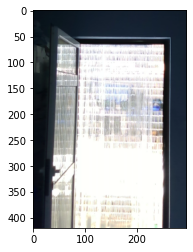

Dimension Image : (420, 296, 3)


In [8]:
IMG_SIZE = 140

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array, cmap ='gray')
plt.show()

print(f"Dimension Image : {img_array.shape}")

### Images Valid

In [9]:
Open_valid = len(os.listdir("DataSet_Classification/Cropped/RGB/val/Open"))
Semi_valid = len(os.listdir("DataSet_Classification/Cropped/RGB/val/Semi"))
Closed_valid = len(os.listdir("DataSet_Classification/Cropped/RGB/val/Closed"))

print(f"Nombre d\'images Open : {Open_valid}")
print(f"Nombre d\'images Semi : {Semi_valid}")
print(f"Nombre d\'images Closed : {Closed_valid}")

Nombre d'images Open : 20
Nombre d'images Semi : 20
Nombre d'images Closed : 20


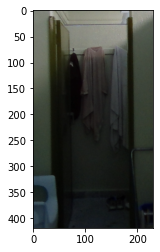

Dimension Image : (419, 231, 3)


In [13]:
IMG_SIZE = 140

for category in categories_val:
    path = os.path.join(data_direction_val, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array, cmap ='gray')
plt.show()

print(f"Dimension Image : {img_array.shape}")

### Résumé

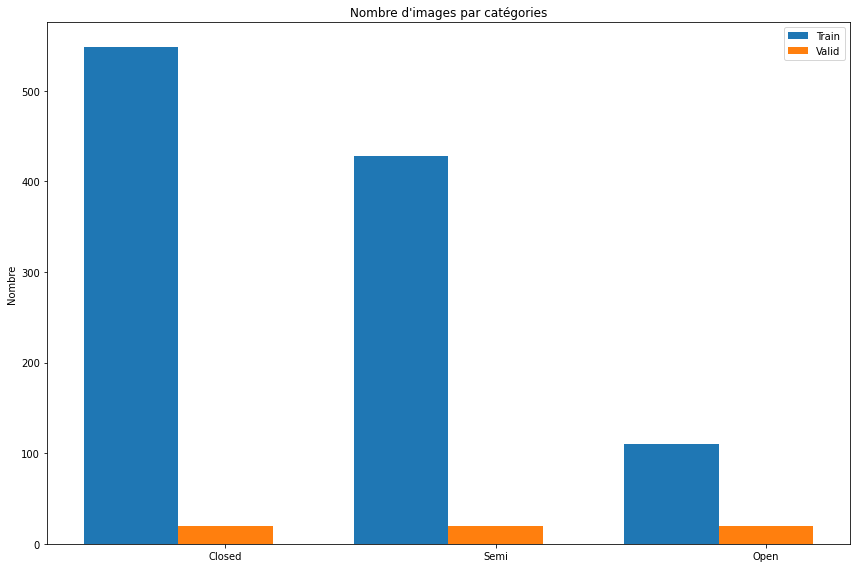

In [14]:
nb_train = [Open_train, Closed_train, Semi_train]
nb_valid = [Open_valid, Closed_valid, Semi_valid]

# width of the bars
barWidth = 0.35

# The x position of bars
r1 = np.arange(len(nb_train))
r2 = [x + barWidth for x in r1]

plt.figure(figsize = (12,8))

plt.bar(r1, nb_train, width = barWidth,  capsize=7, label='Train')
plt.bar(r2, nb_valid, width = barWidth,  capsize=7, label='Valid')
 
# general layout
plt.xticks([r + barWidth for r in range(len(nb_train))], categories_val)
plt.ylabel('Nombre')
plt.title('Nombre d\'images par catégories')
plt.legend()

plt.tight_layout()

plt.show()

## Listes X_train / X_valid et Labels

Dimension : (140, 140, 3)


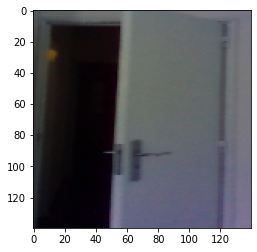

In [15]:
# Création des listes et redimensionnement:
data_list_train = []
data_list_val = []
data_list_test = []

def data_list(liste, categories, data_direction):
    for category in categories:
        path = os.path.join(data_direction, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            liste.append([new_array, class_num])

data_list(data_list_train, categories_train, data_direction_train)
data_list(data_list_val, categories_val, data_direction_val)
data_list(data_list_test, categories_test, data_direction_test)

n = 456
print(f"Dimension : {data_list_train[n][0].shape}")
plt.imshow(np.uint8(data_list_train[n][0]), cmap='gray')

plt.show()

In [16]:
# Mélange des images dans chaque liste X/labels:
random.seed(40)
random.shuffle(data_list_train)
random.shuffle(data_list_val)

In [17]:
print(f'Train : {len(data_list_train)}')
print(f'Val : {len(data_list_val)}')

Train : 1086
Val : 60


In [18]:
# Initialisation des jeux de données et normalisation:
x_app = []
y_app = []
x_val = []
y_val = []

for feature, label in data_list_train :
    x_app.append(feature)
    y_app.append(label)

for feature, label in data_list_val :
    x_val.append(feature)
    y_val.append(label)


x_app = np.array(x_app).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_app = np.array(y_app)

x_val = np.array(x_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array(y_val)

x_app = x_app.astype('float')/255
x_val = x_val.astype('float')/255

print("x_app.shape :\t ", x_app.shape)
print("x_val.shape :\t ", x_val.shape)
print("y_app.shape :\t ", y_app.shape)
print("y_val.shape :\t ", y_val.shape)

x_app.shape :	  (1086, 140, 140, 3)
x_val.shape :	  (60, 140, 140, 3)
y_app.shape :	  (1086,)
y_val.shape :	  (60,)


In [19]:
# Redimensionnement des labels:
y_app = keras.utils.to_categorical(y_app, 3)
y_val = keras.utils.to_categorical(y_val, 3)

print("y_app.shape :\t ",y_app.shape)
print("y_val.shape :\t ",y_val.shape)

y_app.shape :	  (1086, 3)
y_val.shape :	  (60, 3)


[0. 1. 0.]


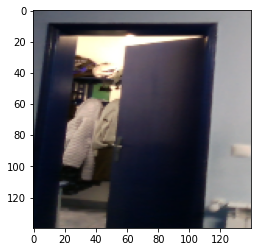

In [34]:
n = 4
print(y_app[n])
plt.imshow(np.uint8(data_list_train[n][0]), cmap='gray')
plt.show()

## Modèle de classification

In [20]:
# Création du réseau CNN:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation ='relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Conv2D(128, kernel_size = (3, 3), activation ='relu'))
model.add(tf.keras.layers.Conv2D(256, kernel_size = (3, 3), activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer ='adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 138, 138, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 136, 136, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 68, 68, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 66, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                    

In [22]:
# Data-augmentation:
augmentation = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.15,
                                shear_range=0.15,
                                horizontal_flip=False,
                                vertical_flip=False,
                                fill_mode="nearest")

In [35]:
# Sauvegarde des poids permettant d'obtenir les performances optimales du modèle entrainé:
checkpoint_filepath = '/content/gdrive/My Drive/microsoft_ia/IA/Models/best_class_4.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Apprentissage:
history = model.fit(augmentation.flow(x_app, y_app, batch_size=16), epochs=50, validation_data=(x_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/50
68/68 [==============================] - 21s 148ms/step - loss: 1.0259 - accuracy: 0.6068 - val_loss: 1.1003 - val_accuracy: 0.5000
Epoch 2/50
68/68 [==============================] - 9s 130ms/step - loss: 0.6577 - accuracy: 0.7495 - val_loss: 0.6351 - val_accuracy: 0.7833
Epoch 3/50
68/68 [==============================] - 8s 114ms/step - loss: 0.5005 - accuracy: 0.8186 - val_loss: 0.4604 - val_accuracy: 0.7833
Epoch 4/50
68/68 [==============================] - 9s 126ms/step - loss: 0.3927 - accuracy: 0.8536 - val_loss: 0.3288 - val_accuracy: 0.8833
Epoch 5/50
68/68 [==============================] - 8s 111ms/step - loss: 0.3100 - accuracy: 0.8923 - val_loss: 0.4221 - val_accuracy: 0.8500
Epoch 6/50
68/68 [==============================] - 8s 114ms/step - loss: 0.3187 - accuracy: 0.8858 - val_loss: 0.3459 - val_accuracy: 0.8167
Epoch 7/50
68/68 [==============================] - 8s 112ms/step - loss: 0.3291 - accuracy: 0.8757 - val_loss: 0.3608 - val_accuracy: 0.8500
Epoch

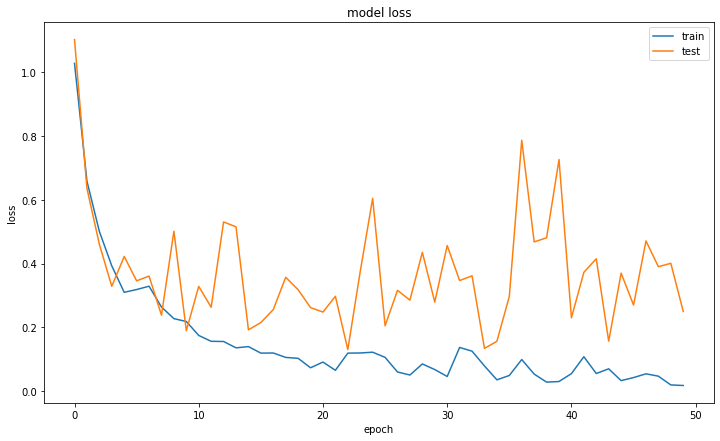

In [36]:
# Courbe d'apprentissage sur la métrique Loss categorical_crossentropy:
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

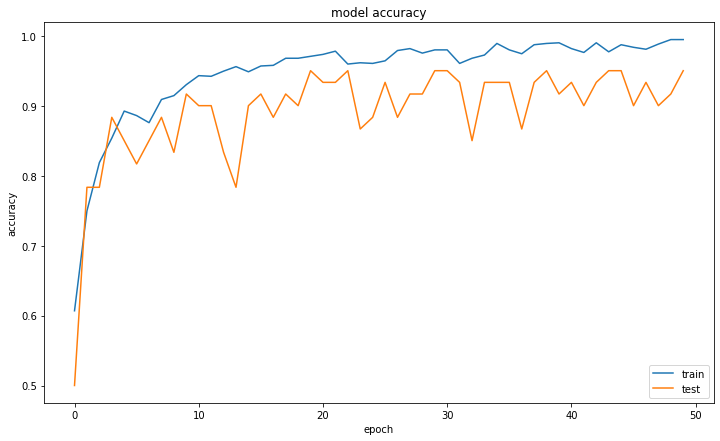

In [37]:
# Courbe d'apprentissage sur la métrique Accuracy:
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [38]:
# Evaluation:
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred,axis=1)
y_val_max = np.argmax(y_val,axis=1)
print('Précision sur les données Validation : ', accuracy_score(y_val_max, y_pred))

Précision sur les données Validation :  0.95


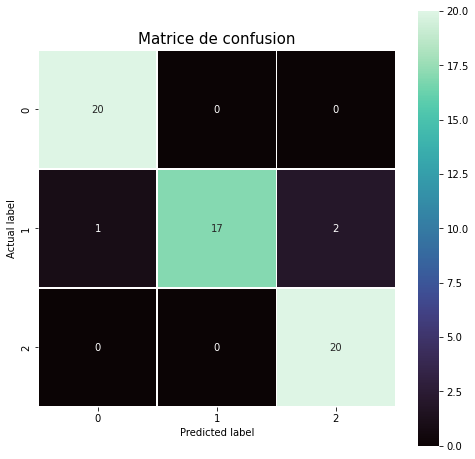

In [39]:
# Matrice de Confusion:
c_m = confusion_matrix(y_val_max, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()

##Sauvegarde du modèle et poids

In [48]:
model.save("/content/gdrive/My Drive/microsoft_ia/IA/Models/classifier_r4.h5")

2/2 - 0s - loss: 0.2622 - accuracy: 0.9500 - 461ms/epoch - 230ms/step
Restored model, accuracy: 95.00%


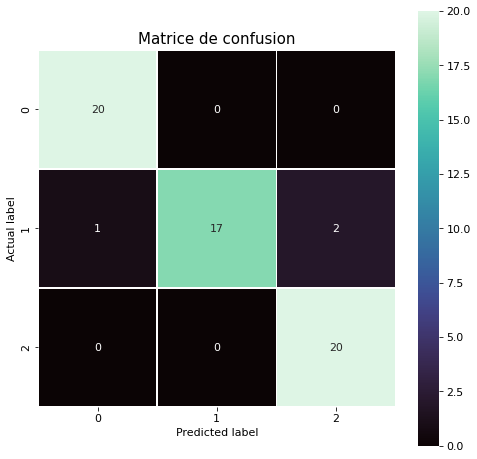

In [60]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/microsoft_ia/IA/Models/classifier_r4.h5')
model.load_weights('/content/gdrive/My Drive/microsoft_ia/IA/Models/best_class_4.h5')

# Evaluation après rechargement du modèle sauvegardé:
loss, acc = model.evaluate(x_val, y_val, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
classication = model.predict(x_val)
y_pred = np.argmax(classication,axis=1)

# Matrice de Confusion:
c_m = confusion_matrix(y_val_max, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()

x_test.shape :	  (60, 140, 140, 3)
y_test.shape :	  (60, 3)


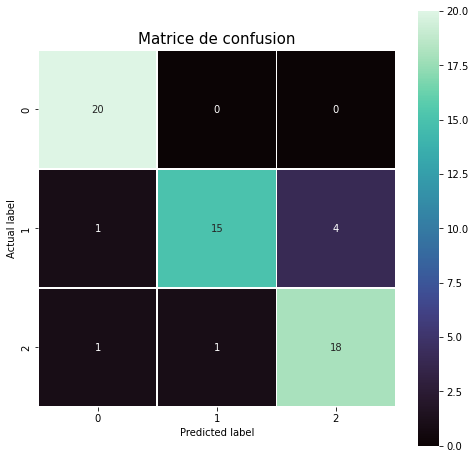

In [45]:
# Mélange des images dans chaque liste (X,labels):
random.seed(42)
random.shuffle(data_list_test)

# Initialisation des jeux de données et normalisation:
x_test = []
y_test = []

for feature, label in data_list_test :
    x_test.append(feature)
    y_test.append(label)

x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

x_test = x_test.astype('float')/255
y_test = keras.utils.to_categorical(y_test, 3)

print("x_test.shape :\t ", x_test.shape)
print("y_test.shape :\t ", y_test.shape)

# Evaluation après rechargement du modèle sauvegardé:
classication = model.predict(x_test)
y_pred = np.argmax(classication,axis=1)
y_test_max = np.argmax(y_test,axis=1)

# Matrice de Confusion:
c_m = confusion_matrix(y_test_max, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()

# Test du modèle avec Détection et Classification des Portes

In [46]:
# Chargement du modèle YOLO de détection de porte:
import torch
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/gdrive/My Drive/microsoft_ia/IA/Models/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-4-5 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


[0]


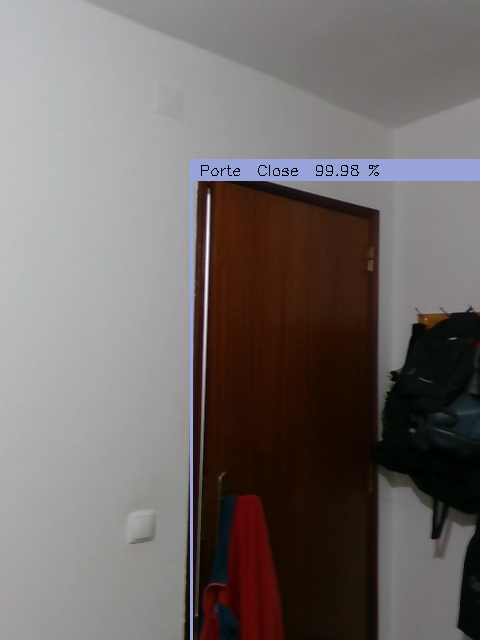

In [47]:
# Détection et classification de l'image de porte:
Label = [' Porte ']
l_c = ['Close', 'Entre-ouverte', 'Ouverte']

font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(2, 3))
boxes = []
classid = 0

CONFIDENCE_THRESHOLD = 0.5

# Import d'une image OriginalSize:
Img = cv2.imread('DataSet_Classification/OriginalSize/RGB/test/Closed/door0000528.png')
results = model_yolo(Img)

IMG_SIZE = 140

# Création des boxes de détection générées par le modèle YOLO:
for i in range(0,len(results.pred[0])) :
    if results.pred[0][i,4] > CONFIDENCE_THRESHOLD :
        
        x = int(results.pred[0][i,0])
        y = int(results.pred[0][i,1])
        w = int(results.pred[0][i,2])
        h = int(results.pred[0][i,3])
        box = np.array([x, y, w, h])
        boxes.append(box)

# Incorporation du modèle classifier, prédisant la classe à partir des boxes générées par YOLO:    
for box in boxes:
    color = colors[int(classid) % len(colors)]
    crop = [(box[0], box[1]), (box[1]+box[2], box[1]+box[3])]

    cv2.rectangle(Img, (box[0],box[1]), (box[1]+box[2],box[1]+box[3]), color, 2)
    cv2.rectangle(Img, (box[0], box[1]), (box[1] + box[2], box[1]+20), color, -1)
    
    # Traitement de l'image de la box (faisant office d'image croppée):
    crop_img = Img[crop[0][1]:crop[1][1], crop[0][0]:crop[1][0]]
    new_array = cv2.resize(crop_img, (IMG_SIZE, IMG_SIZE))
    x_test = np.array(new_array).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    x_test = x_test.astype('float')/255

    # Prédiction avec probabilité à partir du classifier pour définir le statut de la porte:
    classication = model.predict(x_test)
    y_pred = np.argmax(classication,axis=1)
    name = f' {l_c[y_pred[0]]} '
    probability = f' {round(classication.max()*100, 2)} %'
    cv2.putText(Img, Label[classid]+name+probability, (box[0], box[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0)) 
    print(y_pred)

cv2_imshow(Img)

cv2.waitKey(0)
cv2.destroyAllWindows()